In [1]:
# Business Logic & Threshold Optimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve
)
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load saved model and metadata
print("📂 Loading saved model...")

# Load model
model_path = '../models/fraud_detector_xgboost.pkl'
model = joblib.load(model_path)
print(f"✅ Model loaded from: {model_path}")

# Load metadata
metadata_path = '../models/model_metadata.json'
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"\n📊 Model Info:")
print(f"  Type: {metadata['model_info']['type']}")
print(f"  Training Date: {metadata['model_info']['training_date']}")
print(f"\n🎯 Current Performance:")
for metric, value in metadata['performance'].items():
    print(f"  {metric}: {value:.4f}")

📂 Loading saved model...
✅ Model loaded from: ../models/fraud_detector_xgboost.pkl

📊 Model Info:
  Type: XGBoost Classifier
  Training Date: 2026-02-10 15:28:53

🎯 Current Performance:
  accuracy: 0.9984
  precision: 0.5319
  recall: 0.8446
  f1_score: 0.6527
  roc_auc: 0.9751


In [4]:
# Reload dataset to get predictions
print("\n📂 Loading dataset for threshold testing...")

from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('../data/creditcard.csv')

# Feature engineering (same as training)
df['Hour'] = (df['Time'] / 3600) % 24
df['Amount_Log'] = np.log1p(df['Amount'])

# Prepare data
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']

# Same split as training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Get predictions
y_pred_default = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f"✅ Data loaded and predictions generated!")
print(f"   Test samples: {len(X_test)}")
print(f"   Actual frauds: {y_test.sum()}")
print(f"   Default predictions (threshold=0.5): {y_pred_default.sum()}")



📂 Loading dataset for threshold testing...
✅ Data loaded and predictions generated!
   Test samples: 85443
   Actual frauds: 148
   Default predictions (threshold=0.5): 235


In [5]:
# Test different thresholds
print("🔍 THRESHOLD ANALYSIS")
print("="*80)

thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for threshold in thresholds_to_test:
    # Apply threshold
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    # Count predictions
    frauds_detected = y_pred_thresh.sum()
    true_frauds = ((y_pred_thresh == 1) & (y_test == 1)).sum()
    false_alarms = ((y_pred_thresh == 1) & (y_test == 0)).sum()
    
    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Frauds_Detected': frauds_detected,
        'True_Frauds': true_frauds,
        'False_Alarms': false_alarms
    })
    
    print(f"\nThreshold: {threshold:.1f}")
    print(f"  Precision: {precision:>6.1%}  |  Recall: {recall:>6.1%}  |  F1: {f1:.4f}")
    print(f"  Total Alerts: {frauds_detected:>3}  (True: {true_frauds:>3}, False: {false_alarms:>3})")

# Create DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("\n📊 SUMMARY TABLE:")
print(results_df.to_string(index=False))




🔍 THRESHOLD ANALYSIS

Threshold: 0.3
  Precision:  36.0%  |  Recall:  85.1%  |  F1: 0.5060
  Total Alerts: 350  (True: 126, False: 224)

Threshold: 0.4
  Precision:  45.7%  |  Recall:  85.1%  |  F1: 0.5943
  Total Alerts: 276  (True: 126, False: 150)

Threshold: 0.5
  Precision:  53.2%  |  Recall:  84.5%  |  F1: 0.6527
  Total Alerts: 235  (True: 125, False: 110)

Threshold: 0.6
  Precision:  61.9%  |  Recall:  84.5%  |  F1: 0.7143
  Total Alerts: 202  (True: 125, False:  77)

Threshold: 0.7
  Precision:  70.2%  |  Recall:  84.5%  |  F1: 0.7669
  Total Alerts: 178  (True: 125, False:  53)

Threshold: 0.8
  Precision:  75.2%  |  Recall:  83.8%  |  F1: 0.7923
  Total Alerts: 165  (True: 124, False:  41)

Threshold: 0.9
  Precision:  81.1%  |  Recall:  81.1%  |  F1: 0.8108
  Total Alerts: 148  (True: 120, False:  28)


📊 SUMMARY TABLE:
 Threshold  Precision   Recall  F1-Score  Frauds_Detected  True_Frauds  False_Alarms
       0.3   0.360000 0.851351  0.506024              350          126

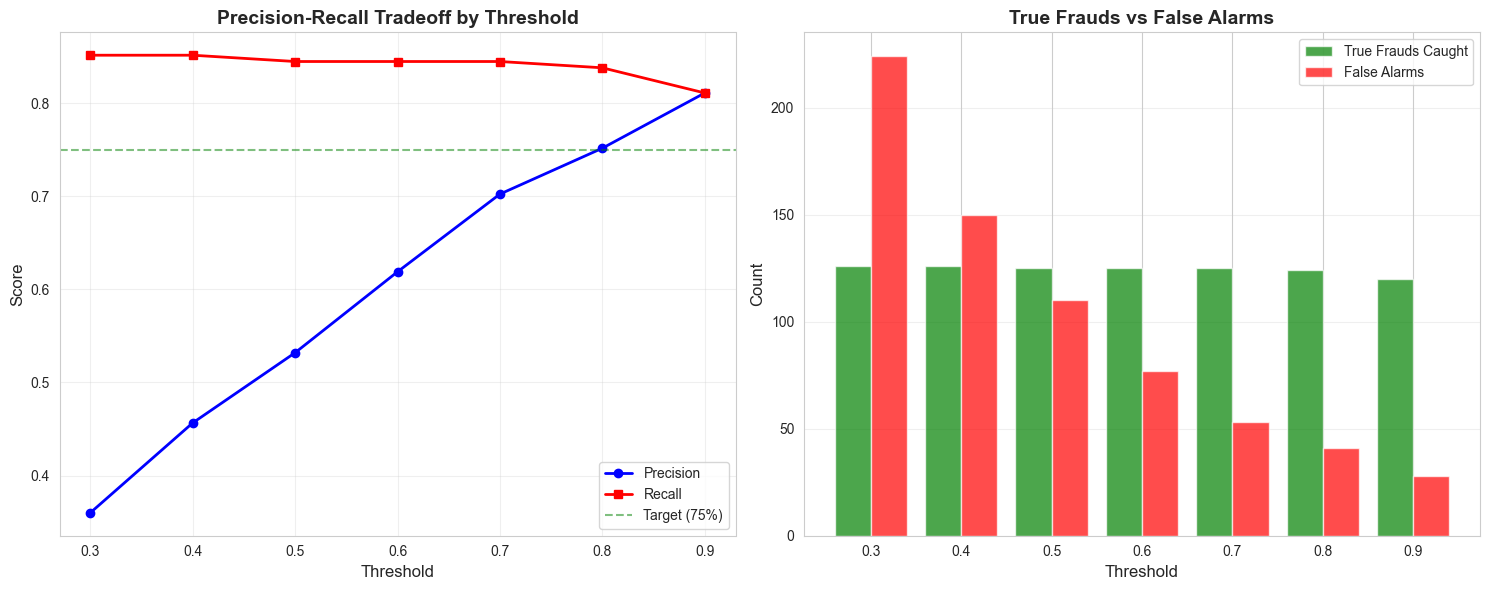

✅ Threshold analysis visualized!


In [6]:
# Visualize precision-recall tradeoff
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Precision vs Recall
axes[0].plot(results_df['Threshold'], results_df['Precision'], 
             marker='o', label='Precision', linewidth=2, color='blue')
axes[0].plot(results_df['Threshold'], results_df['Recall'], 
             marker='s', label='Recall', linewidth=2, color='red')
axes[0].axhline(y=0.75, color='green', linestyle='--', alpha=0.5, label='Target (75%)')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Precision-Recall Tradeoff by Threshold', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: True vs False Alarms
x_pos = np.arange(len(results_df))
axes[1].bar(x_pos - 0.2, results_df['True_Frauds'], width=0.4, 
            label='True Frauds Caught', color='green', alpha=0.7)
axes[1].bar(x_pos + 0.2, results_df['False_Alarms'], width=0.4, 
            label='False Alarms', color='red', alpha=0.7)
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('True Frauds vs False Alarms', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Threshold'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Threshold analysis visualized!")

In [7]:
# Define business costs (in rupees)
print("💰 BUSINESS COST ANALYSIS")
print("="*80)

# Cost assumptions
FRAUD_LOSS_PER_CASE = 10000      # Average fraud amount: ₹10,000
FALSE_POSITIVE_COST = 500         # Customer friction + manual review: ₹500
MANUAL_REVIEW_COST = 200          # Cost to review one alert: ₹200

print(f"\n📋 Cost Assumptions:")
print(f"  Fraud Loss (per missed fraud):     ₹{FRAUD_LOSS_PER_CASE:,}")
print(f"  False Alarm Cost (per FP):         ₹{FALSE_POSITIVE_COST:,}")
print(f"  Manual Review Cost (per alert):    ₹{MANUAL_REVIEW_COST:,}")

# Calculate costs for each threshold
total_frauds = y_test.sum()

for idx, row in results_df.iterrows():
    threshold = row['Threshold']
    true_positives = row['True_Frauds']
    false_positives = row['False_Alarms']
    false_negatives = total_frauds - true_positives
    
    # Calculate costs
    fraud_loss = false_negatives * FRAUD_LOSS_PER_CASE
    false_alarm_cost = false_positives * FALSE_POSITIVE_COST
    review_cost = (true_positives + false_positives) * MANUAL_REVIEW_COST
    
    total_cost = fraud_loss + false_alarm_cost + review_cost
    
    # Calculate savings (if we caught all frauds)
    potential_fraud_loss = total_frauds * FRAUD_LOSS_PER_CASE
    savings = potential_fraud_loss - total_cost
    
    # Add to results
    results_df.loc[idx, 'Fraud_Loss'] = fraud_loss
    results_df.loc[idx, 'False_Alarm_Cost'] = false_alarm_cost
    results_df.loc[idx, 'Review_Cost'] = review_cost
    results_df.loc[idx, 'Total_Cost'] = total_cost
    results_df.loc[idx, 'Net_Savings'] = savings

print(f"\n💵 Total Potential Fraud Loss (if no detection): ₹{potential_fraud_loss:,}")
print("\n" + "="*80)

💰 BUSINESS COST ANALYSIS

📋 Cost Assumptions:
  Fraud Loss (per missed fraud):     ₹10,000
  False Alarm Cost (per FP):         ₹500
  Manual Review Cost (per alert):    ₹200

💵 Total Potential Fraud Loss (if no detection): ₹1,480,000



In [8]:
# Display cost analysis
print("\n💰 COST-BENEFIT ANALYSIS BY THRESHOLD:")
print("="*100)

cost_df = results_df[['Threshold', 'Recall', 'Precision', 
                       'Fraud_Loss', 'False_Alarm_Cost', 
                       'Review_Cost', 'Total_Cost', 'Net_Savings']].copy()

# Format for display
for col in ['Fraud_Loss', 'False_Alarm_Cost', 'Review_Cost', 'Total_Cost', 'Net_Savings']:
    cost_df[col] = cost_df[col].apply(lambda x: f"₹{x:,.0f}")

cost_df['Recall'] = cost_df['Recall'].apply(lambda x: f"{x:.1%}")
cost_df['Precision'] = cost_df['Precision'].apply(lambda x: f"{x:.1%}")

print(cost_df.to_string(index=False))
print("="*100)

# Find optimal threshold
optimal_idx = results_df['Net_Savings'].idxmax()
optimal_threshold = results_df.loc[optimal_idx, 'Threshold']
optimal_savings = results_df.loc[optimal_idx, 'Net_Savings']
optimal_recall = results_df.loc[optimal_idx, 'Recall']
optimal_precision = results_df.loc[optimal_idx, 'Precision']

print(f"\n🎯 OPTIMAL THRESHOLD: {optimal_threshold:.2f}")
print(f"   Net Savings:  ₹{optimal_savings:,.0f}")
print(f"   Recall:       {optimal_recall:.1%}")
print(f"   Precision:    {optimal_precision:.1%}")



💰 COST-BENEFIT ANALYSIS BY THRESHOLD:
 Threshold Recall Precision Fraud_Loss False_Alarm_Cost Review_Cost Total_Cost Net_Savings
       0.3  85.1%     36.0%   ₹220,000         ₹112,000     ₹70,000   ₹402,000  ₹1,078,000
       0.4  85.1%     45.7%   ₹220,000          ₹75,000     ₹55,200   ₹350,200  ₹1,129,800
       0.5  84.5%     53.2%   ₹230,000          ₹55,000     ₹47,000   ₹332,000  ₹1,148,000
       0.6  84.5%     61.9%   ₹230,000          ₹38,500     ₹40,400   ₹308,900  ₹1,171,100
       0.7  84.5%     70.2%   ₹230,000          ₹26,500     ₹35,600   ₹292,100  ₹1,187,900
       0.8  83.8%     75.2%   ₹240,000          ₹20,500     ₹33,000   ₹293,500  ₹1,186,500
       0.9  81.1%     81.1%   ₹280,000          ₹14,000     ₹29,600   ₹323,600  ₹1,156,400

🎯 OPTIMAL THRESHOLD: 0.70
   Net Savings:  ₹1,187,900
   Recall:       84.5%
   Precision:    70.2%


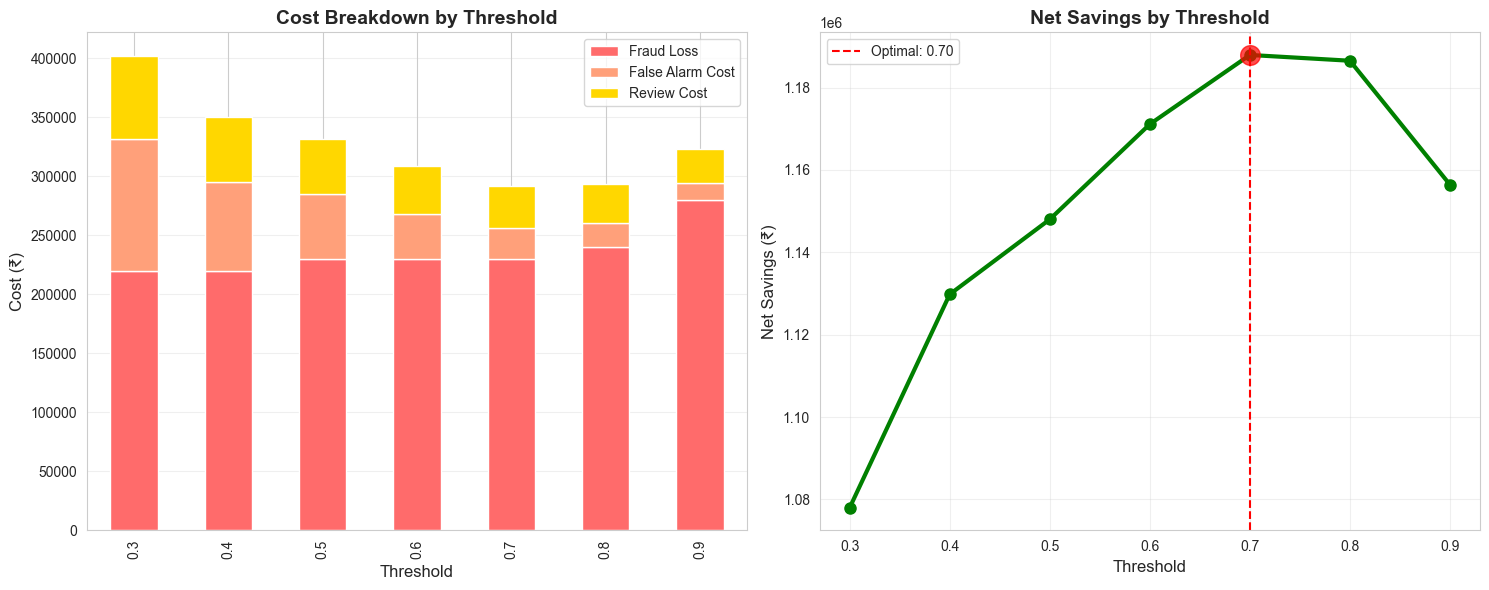

✅ Cost-benefit analysis complete!


In [9]:
# Visualize cost-benefit
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Cost Breakdown
cost_components = results_df[['Threshold', 'Fraud_Loss', 'False_Alarm_Cost', 'Review_Cost']]
cost_components.set_index('Threshold').plot(kind='bar', stacked=True, ax=axes[0], 
                                             color=['#FF6B6B', '#FFA07A', '#FFD700'])
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Cost (₹)', fontsize=12)
axes[0].set_title('Cost Breakdown by Threshold', fontsize=14, fontweight='bold')
axes[0].legend(['Fraud Loss', 'False Alarm Cost', 'Review Cost'])
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Net Savings
axes[1].plot(results_df['Threshold'], results_df['Net_Savings'], 
             marker='o', linewidth=3, color='green', markersize=8)
axes[1].axvline(x=optimal_threshold, color='red', linestyle='--', 
                label=f'Optimal: {optimal_threshold:.2f}')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Net Savings (₹)', fontsize=12)
axes[1].set_title('Net Savings by Threshold', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Highlight optimal point
axes[1].scatter([optimal_threshold], [optimal_savings], 
                color='red', s=200, zorder=5, alpha=0.7)

plt.tight_layout()
plt.show()

print("✅ Cost-benefit analysis complete!")

In [10]:
# Create 3-tier risk strategy
print("⚠️ RISK STRATEGY ENGINE")
print("="*80)

# Define risk thresholds
LOW_RISK_THRESHOLD = 0.4
HIGH_RISK_THRESHOLD = 0.7

def classify_risk(probability):
    """Classify transaction into risk levels"""
    if probability < LOW_RISK_THRESHOLD:
        return 'Low'
    elif probability < HIGH_RISK_THRESHOLD:
        return 'Medium'
    else:
        return 'High'

# Apply risk classification
risk_levels = np.array([classify_risk(p) for p in y_pred_proba])

# Create risk strategy dataframe
risk_df = pd.DataFrame({
    'Probability': y_pred_proba,
    'Risk_Level': risk_levels,
    'Actual_Fraud': y_test.values
})

print("\n📊 Risk Level Distribution:")
print(risk_df['Risk_Level'].value_counts())

print("\n🎯 Fraud Rate by Risk Level:")
for level in ['Low', 'Medium', 'High']:
    subset = risk_df[risk_df['Risk_Level'] == level]
    fraud_rate = subset['Actual_Fraud'].mean() * 100
    count = len(subset)
    frauds = subset['Actual_Fraud'].sum()
    print(f"  {level:6} Risk: {fraud_rate:5.2f}% fraud rate  ({frauds:3}/{count:5} transactions)")


⚠️ RISK STRATEGY ENGINE

📊 Risk Level Distribution:
Risk_Level
Low       85167
High        178
Medium       98
Name: count, dtype: int64

🎯 Fraud Rate by Risk Level:
  Low    Risk:  0.03% fraud rate  ( 22/85167 transactions)
  Medium Risk:  1.02% fraud rate  (  1/   98 transactions)
  High   Risk: 70.22% fraud rate  (125/  178 transactions)


In [11]:
# Define actions for each risk level
print("\n🎬 ACTION STRATEGY BY RISK LEVEL:")
print("="*80)

actions = {
    'Low': {
        'action': 'Auto-Approve',
        'description': 'Transaction approved automatically',
        'customer_impact': 'Seamless experience',
        'cost_per_transaction': 0
    },
    'Medium': {
        'action': 'Request OTP/2FA',
        'description': 'Additional verification required',
        'customer_impact': 'Minor friction (30 seconds)',
        'cost_per_transaction': 50  # SMS + verification cost
    },
    'High': {
        'action': 'Block + Manual Review',
        'description': 'Transaction blocked, analyst reviews',
        'customer_impact': 'Blocked until verified',
        'cost_per_transaction': 200  # Manual review cost
    }
}

for level, action_info in actions.items():
    count = (risk_levels == level).sum()
    print(f"\n{level.upper()} RISK ({count:,} transactions):")
    print(f"  Action: {action_info['action']}")
    print(f"  Impact: {action_info['customer_impact']}")
    print(f"  Cost:   ₹{action_info['cost_per_transaction']} per transaction")


🎬 ACTION STRATEGY BY RISK LEVEL:

LOW RISK (85,167 transactions):
  Action: Auto-Approve
  Impact: Seamless experience
  Cost:   ₹0 per transaction

MEDIUM RISK (98 transactions):
  Action: Request OTP/2FA
  Impact: Minor friction (30 seconds)
  Cost:   ₹50 per transaction

HIGH RISK (178 transactions):
  Action: Block + Manual Review
  Impact: Blocked until verified
  Cost:   ₹200 per transaction


In [12]:
# Calculate performance of risk strategy
print("\n📈 RISK STRATEGY PERFORMANCE:")
print("="*80)

# Count outcomes by risk level
for level in ['Low', 'Medium', 'High']:
    level_mask = risk_levels == level
    level_data = risk_df[level_mask]
    
    total = len(level_data)
    frauds = level_data['Actual_Fraud'].sum()
    normals = total - frauds
    
    action_cost = actions[level]['cost_per_transaction']
    total_cost = total * action_cost
    
    # Fraud loss (for Low and Medium, frauds slip through)
    if level == 'Low':
        fraud_loss = frauds * FRAUD_LOSS_PER_CASE
    elif level == 'Medium':
        # Assume 50% frauds caught with OTP
        fraud_loss = (frauds * 0.5) * FRAUD_LOSS_PER_CASE
    else:  # High
        # Manual review catches 95% frauds
        fraud_loss = (frauds * 0.05) * FRAUD_LOSS_PER_CASE
    
    print(f"\n{level.upper()} RISK:")
    print(f"  Transactions: {total:,}")
    print(f"  Frauds:       {frauds}")
    print(f"  Action Cost:  ₹{total_cost:,}")
    print(f"  Fraud Loss:   ₹{fraud_loss:,}")
    print(f"  Total Cost:   ₹{total_cost + fraud_loss:,}")

# Overall strategy cost
low_cost = (risk_levels == 'Low').sum() * actions['Low']['cost_per_transaction']
med_cost = (risk_levels == 'Medium').sum() * actions['Medium']['cost_per_transaction']
high_cost = (risk_levels == 'High').sum() * actions['High']['cost_per_transaction']

low_frauds = risk_df[risk_levels == 'Low']['Actual_Fraud'].sum()
med_frauds = risk_df[risk_levels == 'Medium']['Actual_Fraud'].sum()
high_frauds = risk_df[risk_levels == 'High']['Actual_Fraud'].sum()

low_fraud_loss = low_frauds * FRAUD_LOSS_PER_CASE
med_fraud_loss = (med_frauds * 0.5) * FRAUD_LOSS_PER_CASE
high_fraud_loss = (high_frauds * 0.05) * FRAUD_LOSS_PER_CASE

total_strategy_cost = (low_cost + med_cost + high_cost + 
                       low_fraud_loss + med_fraud_loss + high_fraud_loss)

print("\n" + "="*80)
print(f"🎯 TOTAL STRATEGY COST: ₹{total_strategy_cost:,}")
print(f"   vs Simple Threshold Cost: ₹{results_df.loc[optimal_idx, 'Total_Cost']:,.0f}")
print(f"   SAVINGS: ₹{results_df.loc[optimal_idx, 'Total_Cost'] - total_strategy_cost:,}")


📈 RISK STRATEGY PERFORMANCE:

LOW RISK:
  Transactions: 85,167
  Frauds:       22
  Action Cost:  ₹0
  Fraud Loss:   ₹220,000
  Total Cost:   ₹220,000

MEDIUM RISK:
  Transactions: 98
  Frauds:       1
  Action Cost:  ₹4,900
  Fraud Loss:   ₹5,000.0
  Total Cost:   ₹9,900.0

HIGH RISK:
  Transactions: 178
  Frauds:       125
  Action Cost:  ₹35,600
  Fraud Loss:   ₹62,500.0
  Total Cost:   ₹98,100.0

🎯 TOTAL STRATEGY COST: ₹328,000.0
   vs Simple Threshold Cost: ₹292,100
   SAVINGS: ₹-35,900.0


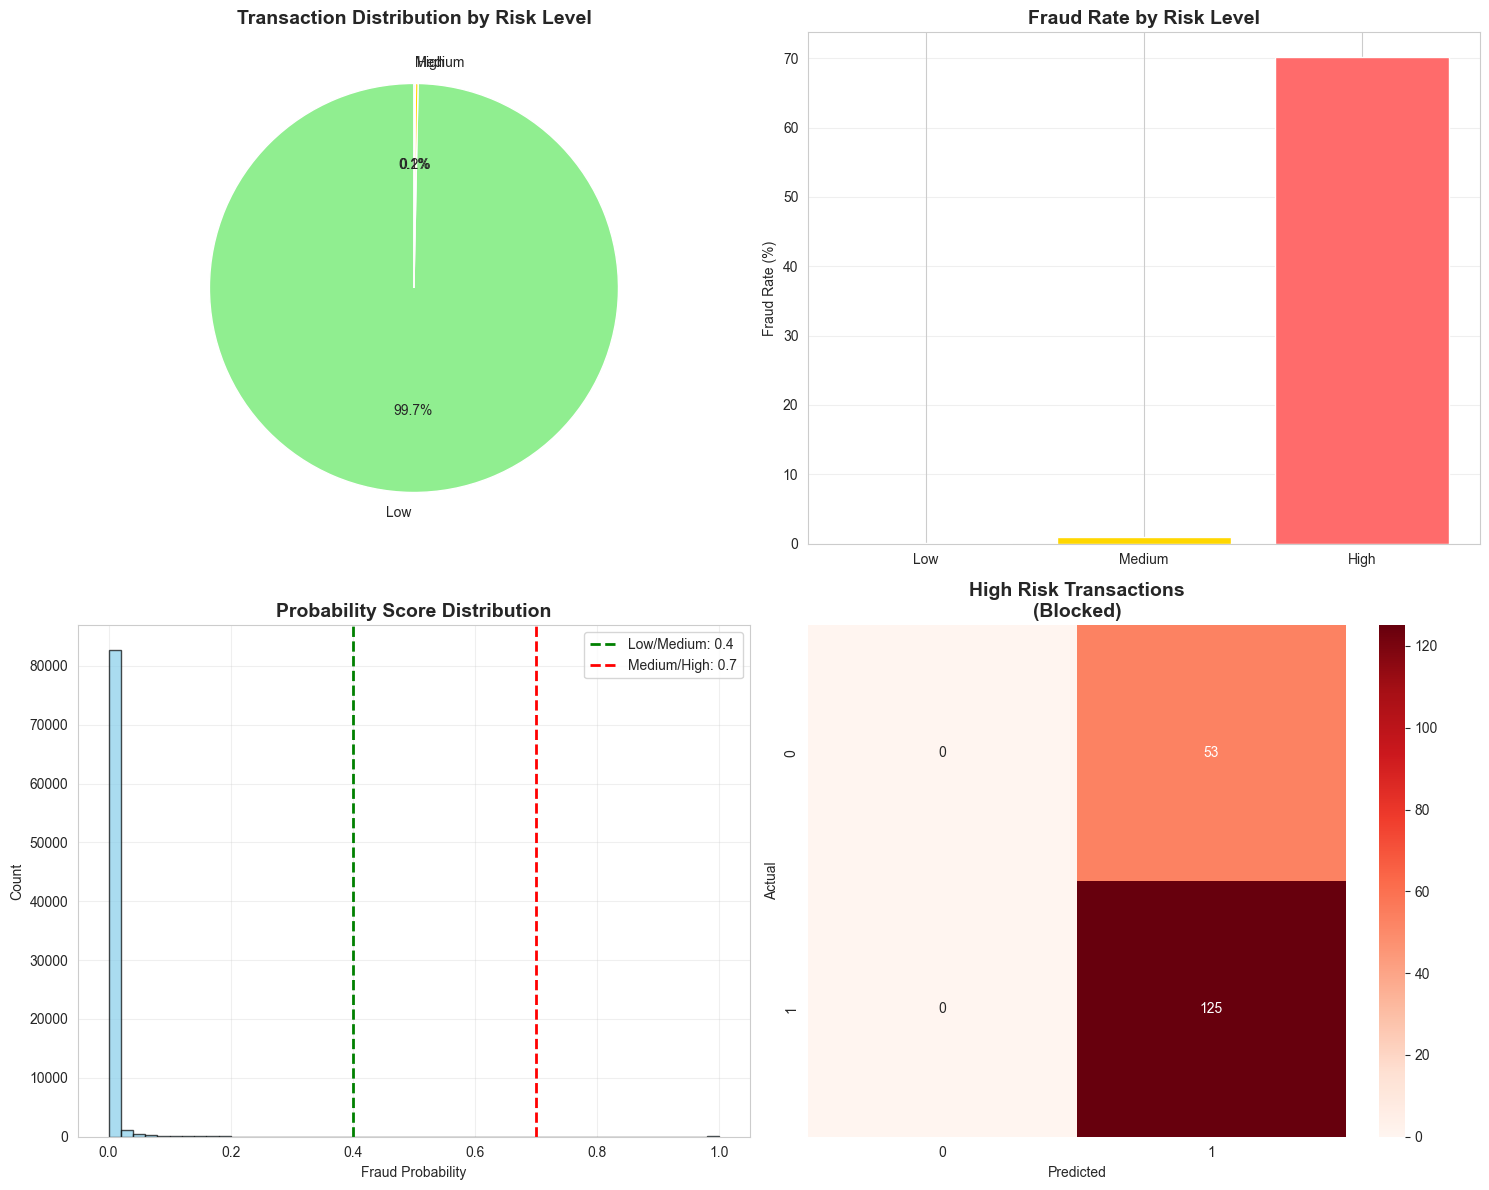

✅ Risk strategy visualized!


In [13]:
# Visualize risk distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Risk Level Distribution
risk_counts = risk_df['Risk_Level'].value_counts()
colors = ['#90EE90', '#FFD700', '#FF6B6B']
axes[0, 0].pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%',
               colors=colors, startangle=90)
axes[0, 0].set_title('Transaction Distribution by Risk Level', 
                      fontsize=14, fontweight='bold')

# Plot 2: Fraud Rate by Level
fraud_rates = []
for level in ['Low', 'Medium', 'High']:
    rate = risk_df[risk_df['Risk_Level'] == level]['Actual_Fraud'].mean() * 100
    fraud_rates.append(rate)

axes[0, 1].bar(['Low', 'Medium', 'High'], fraud_rates, color=colors)
axes[0, 1].set_ylabel('Fraud Rate (%)')
axes[0, 1].set_title('Fraud Rate by Risk Level', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Score Distribution
axes[1, 0].hist(y_pred_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].axvline(LOW_RISK_THRESHOLD, color='green', linestyle='--', 
                    linewidth=2, label=f'Low/Medium: {LOW_RISK_THRESHOLD}')
axes[1, 0].axvline(HIGH_RISK_THRESHOLD, color='red', linestyle='--', 
                    linewidth=2, label=f'Medium/High: {HIGH_RISK_THRESHOLD}')
axes[1, 0].set_xlabel('Fraud Probability')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Probability Score Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Confusion Matrix for High Risk
high_risk_mask = risk_levels == 'High'
y_high_true = y_test[high_risk_mask]
y_high_pred = np.ones(high_risk_mask.sum())  # All predicted as fraud

cm = confusion_matrix(y_high_true, y_high_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[1, 1])
axes[1, 1].set_title('High Risk Transactions\n(Blocked)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

print("✅ Risk strategy visualized!")

In [14]:
# Create custom prediction function with optimal threshold
print("💾 CREATING IMPROVED FRAUD DETECTOR")
print("="*80)

class FraudDetectorOptimized:
    """
    Fraud Detection System with Business Logic
    """
    def __init__(self, model, optimal_threshold=0.7):
        self.model = model
        self.optimal_threshold = optimal_threshold
        self.low_risk_threshold = 0.4
        self.high_risk_threshold = 0.7
    
    def predict_proba(self, X):
        """Get fraud probability"""
        return self.model.predict_proba(X)[:, 1]
    
    def predict(self, X):
        """Predict with optimal threshold"""
        probabilities = self.predict_proba(X)
        return (probabilities >= self.optimal_threshold).astype(int)
    
    def get_risk_level(self, X):
        """Classify into risk levels"""
        probabilities = self.predict_proba(X)
        risk_levels = []
        
        for prob in probabilities:
            if prob < self.low_risk_threshold:
                risk_levels.append('Low')
            elif prob < self.high_risk_threshold:
                risk_levels.append('Medium')
            else:
                risk_levels.append('High')
        
        return np.array(risk_levels)
    
    def get_action(self, X):
        """Recommend action for each transaction"""
        risk_levels = self.get_risk_level(X)
        probabilities = self.predict_proba(X)
        
        actions = []
        for risk, prob in zip(risk_levels, probabilities):
            if risk == 'Low':
                action = 'Approve'
            elif risk == 'Medium':
                action = 'Request OTP'
            else:
                action = 'Block & Review'
            
            actions.append({
                'risk_level': risk,
                'probability': float(prob),
                'action': action
            })
        
        return actions

# Create optimized detector
detector = FraudDetectorOptimized(model, optimal_threshold=optimal_threshold)

print(f"✅ Fraud Detector created!")
print(f"   Optimal Threshold: {optimal_threshold:.2f}")
print(f"   Low Risk:    < {detector.low_risk_threshold}")
print(f"   Medium Risk: {detector.low_risk_threshold} - {detector.high_risk_threshold}")
print(f"   High Risk:   > {detector.high_risk_threshold}")

💾 CREATING IMPROVED FRAUD DETECTOR
✅ Fraud Detector created!
   Optimal Threshold: 0.70
   Low Risk:    < 0.4
   Medium Risk: 0.4 - 0.7
   High Risk:   > 0.7


In [15]:
# Test the improved detector
print("\n🧪 TESTING IMPROVED DETECTOR:")
print("="*80)

# Test on sample transactions
sample_transactions = X_test.iloc[:10]
sample_actuals = y_test.iloc[:10].values

predictions = detector.get_action(sample_transactions)

print("\nSample Predictions:")
print("-"*80)
for i, (pred, actual) in enumerate(zip(predictions, sample_actuals)):
    actual_label = "FRAUD" if actual == 1 else "Normal"
    print(f"\nTransaction {i+1}:")
    print(f"  Probability: {pred['probability']:.4f}")
    print(f"  Risk Level:  {pred['risk_level']}")
    print(f"  Action:      {pred['action']}")
    print(f"  Actual:      {actual_label}")
    print(f"  ✓ Correct!" if (pred['action'] == 'Block & Review' and actual == 1) or 
                              (pred['action'] == 'Approve' and actual == 0) else "  ✗ Miss")


🧪 TESTING IMPROVED DETECTOR:

Sample Predictions:
--------------------------------------------------------------------------------

Transaction 1:
  Probability: 0.0003
  Risk Level:  Low
  Action:      Approve
  Actual:      Normal
  ✓ Correct!

Transaction 2:
  Probability: 0.0015
  Risk Level:  Low
  Action:      Approve
  Actual:      Normal
  ✓ Correct!

Transaction 3:
  Probability: 0.0028
  Risk Level:  Low
  Action:      Approve
  Actual:      Normal
  ✓ Correct!

Transaction 4:
  Probability: 0.0004
  Risk Level:  Low
  Action:      Approve
  Actual:      Normal
  ✓ Correct!

Transaction 5:
  Probability: 0.0009
  Risk Level:  Low
  Action:      Approve
  Actual:      Normal
  ✓ Correct!

Transaction 6:
  Probability: 0.0001
  Risk Level:  Low
  Action:      Approve
  Actual:      Normal
  ✓ Correct!

Transaction 7:
  Probability: 0.0023
  Risk Level:  Low
  Action:      Approve
  Actual:      Normal
  ✓ Correct!

Transaction 8:
  Probability: 0.0017
  Risk Level:  Low
  Acti

In [16]:
# Save optimized detector
import pickle

print("\n💾 Saving optimized fraud detector...")

# Save the detector object
detector_path = '../models/fraud_detector_optimized.pkl'
with open(detector_path, 'wb') as f:
    pickle.dump(detector, f)

# Update metadata
updated_metadata = metadata.copy()
updated_metadata['optimization'] = {
    'optimal_threshold': float(optimal_threshold),
    'low_risk_threshold': 0.4,
    'high_risk_threshold': 0.7,
    'optimization_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'improved_metrics': {
        'precision': float(optimal_precision),
        'recall': float(optimal_recall),
        'net_savings': float(optimal_savings)
    }
}

# Save updated metadata
updated_metadata_path = '../models/model_metadata_optimized.json'
with open(updated_metadata_path, 'w') as f:
    json.dump(updated_metadata, f, indent=4)

print(f"✅ Optimized detector saved!")
print(f"   Location: {detector_path}")
print(f"   Metadata: {updated_metadata_path}")
print(f"\n🎯 Improvement Summary:")
print(f"   Precision: 53.2% → {optimal_precision:.1%} (+{(optimal_precision-0.532)*100:.1f}%)")
print(f"   Recall:    84.5% → {optimal_recall:.1%} ({(optimal_recall-0.845)*100:+.1f}%)")
print(f"   Net Savings: ₹{optimal_savings:,.0f}")


💾 Saving optimized fraud detector...
✅ Optimized detector saved!
   Location: ../models/fraud_detector_optimized.pkl
   Metadata: ../models/model_metadata_optimized.json

🎯 Improvement Summary:
   Precision: 53.2% → 70.2% (+17.0%)
   Recall:    84.5% → 84.5% (-0.0%)
   Net Savings: ₹1,187,900
